In [46]:
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [47]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

#### Combining data from three Donor samples 


In [48]:
# input files
[file for file in os.listdir() if "filtered_feature_bc_matrix.h5" in file]

['Donor1_filtered_feature_bc_matrix.h5',
 'Donor2_filtered_feature_bc_matrix.h5',
 'Donor3_filtered_feature_bc_matrix.h5']

In [ ]:
# reading output files from scvi solo doublet detection

donor1 = pd.read_pickle("donor1_solo_out.pkl")
donor2 = pd.read_pickle("donor2_solo_out.pkl")
donor3 = pd.read_pickle("donor3_solo_out.pkl")

In [50]:
adata1 = sc.read_10x_h5('Donor1_filtered_feature_bc_matrix.h5') 
adata2 = sc.read_10x_h5('Donor2_filtered_feature_bc_matrix.h5') 
adata3 = sc.read_10x_h5('Donor3_filtered_feature_bc_matrix.h5') 

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them u

In [51]:
adata1.var_names_make_unique()
adata1

AnnData object with n_obs × n_vars = 12185 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [52]:
adata2.var_names_make_unique()
adata2

AnnData object with n_obs × n_vars = 13330 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [53]:
adata3.var_names_make_unique()
adata3

AnnData object with n_obs × n_vars = 10949 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [54]:
adata1.obs["revised_prediction"] = donor1["revised_prediction"]
adata2.obs["revised_prediction"] = donor2["revised_prediction"]
adata3.obs["revised_prediction"] = donor3["revised_prediction"]

In [55]:
counts = adata1.obs["revised_prediction"].value_counts().reset_index()
counts

,revised_prediction,count
0,singlet,11358
1,doublet,827


In [56]:
counts = adata2.obs["revised_prediction"].value_counts().reset_index()
counts

,revised_prediction,count
0,singlet,11874
1,doublet,1456


In [57]:
counts = adata3.obs["revised_prediction"].value_counts().reset_index()
counts

,revised_prediction,count
0,singlet,10332
1,doublet,617


In [58]:
adata1 = adata1[adata1.obs["revised_prediction"] != "doublet"].copy()
adata2 = adata2[adata2.obs["revised_prediction"] != "doublet"].copy()
adata3 = adata3[adata3.obs["revised_prediction"] != "doublet"].copy()

In [59]:
adata1.obs['sample'] = 'donor1'
adata2.obs['sample'] = 'donor2'
adata3.obs['sample'] = 'donor3'

#### Same preprocessing for all samples. 


In [ ]:
# (sample wise preörocessing is recommended)

In [60]:
for adata in [adata1, adata2, adata3]:
    adata.var['mt'] = adata.var_names.str.startswith('mt-') 
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    
    sc.pp.filter_genes(adata, min_cells = 3)
    upper_limit = np.quantile(adata.obs.n_genes_by_counts.values, .99)
    adata = adata[adata.obs.n_genes_by_counts < upper_limit]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 20]


In [61]:
adata = sc.concat([adata1, adata2, adata3])

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata.write("combined_adata.h5ad") # we will ise this later for integration

#### Normalize

In [34]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#### Feature selection

In [35]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

#### Dimensionality reduction & Clustering

#### PCA

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


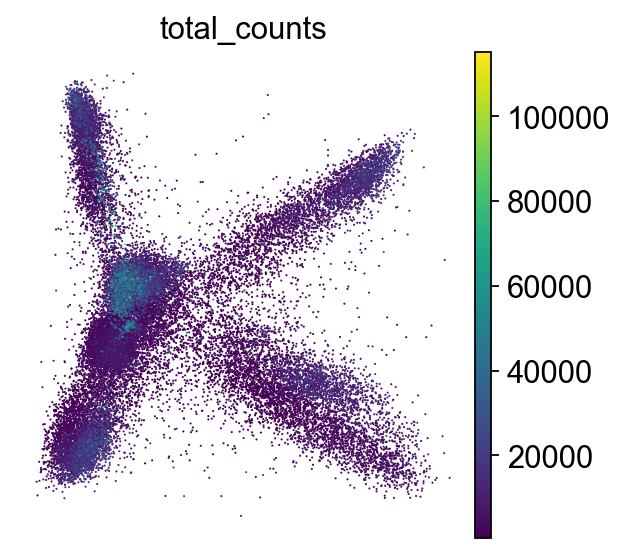

In [36]:
sc.pp.pca(adata, use_highly_variable=True)
sc.pl.pca_scatter(adata, color="total_counts")

#### t-SNE

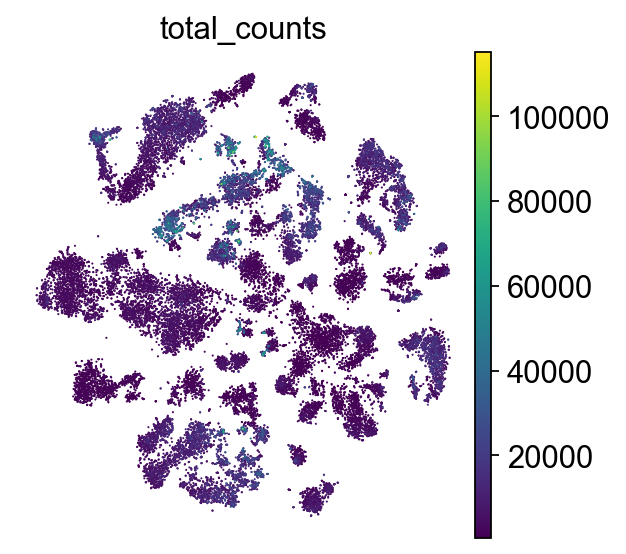

In [37]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color="total_counts")

#### UMAP

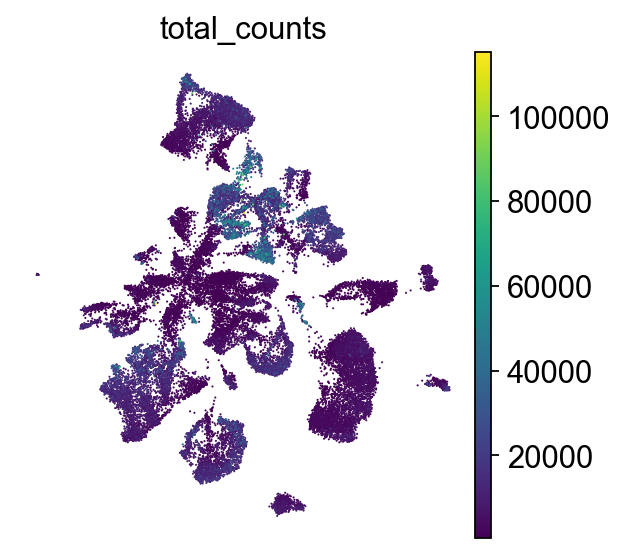

In [38]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="total_counts")

#### Clustering

In [ ]:
# default resolution is 1
# sc.tl.leiden(adata)

C:\Users\19utk\AppData\Local\Temp\ipykernel_51604\3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [43]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

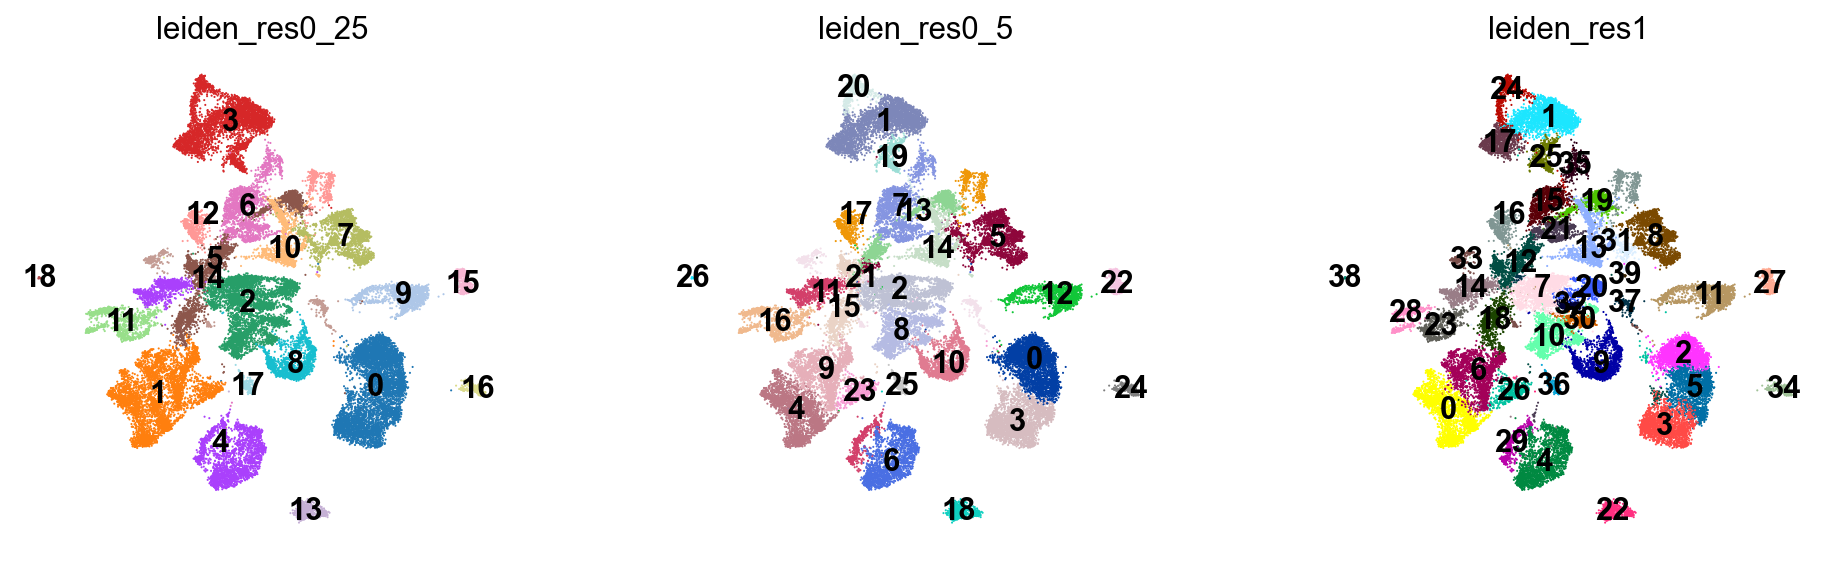

In [44]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [40]:
sc.tl.leiden(adata, resolution=0.25)

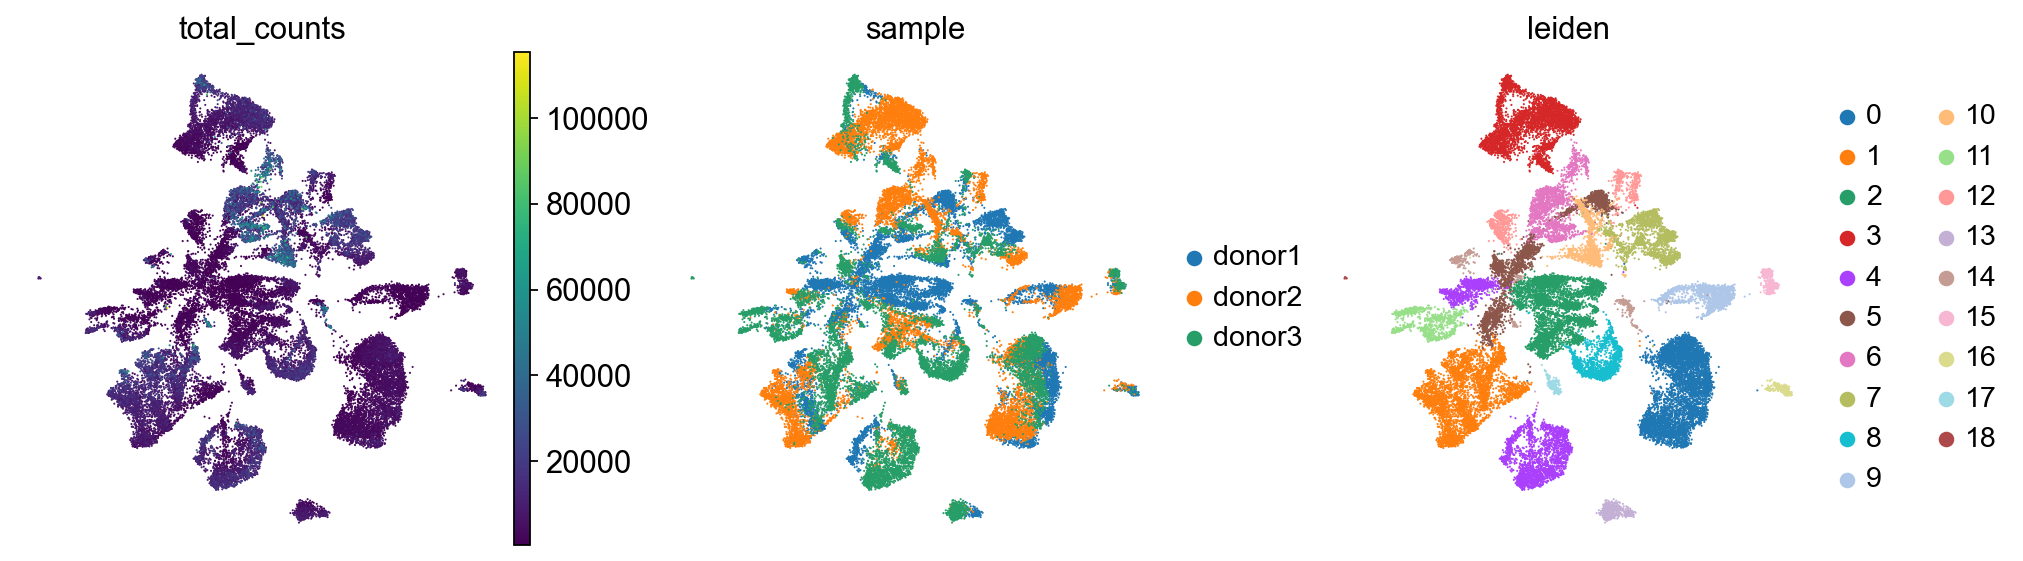

In [ ]:
sc.pl.umap(
    adata,
    color=["total_counts", "sample", "leiden"],
)